In [1]:
import os
import torch
import torchvision
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
from torchvision.utils import make_grid,save_image
from torchvision.datasets import ImageFolder
from IPython.display import Image
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid,save_image

  ##  Dataset Acquisition

We will be using 2 datasets totalling 30000 images

1. **Pokemon_V2 Dataset (kaggle)**

  9002 images from kaggle hub dataset (pokemon v2 , containing augmented images of original 813 images form v1 dataset)
  
  Link: https://www.kaggle.com/datasets/rajatvisitme/pokemon-image-dataset-v2

  the original 813 images are acquired from https://veekun.com/dex/downloads

2. **Pokemon Generation One - 20,100 Gen 1 Pokémon (kaggle)**

  20000 images being a combination of multiple existing datasets - All 151 Pokemon sorted by name

  Link: https://www.kaggle.com/datasets/bhawks/pokemon-generation-one-22k/data


In [2]:
dataset1_path = "/kaggle/input/pokemon-image-dataset-v2"
dataset2_path = "/kaggle/input/pokemon-generation-one-22k"

# Verify paths
print(f"Dataset 1 path: {dataset1_path}")
print(f"Dataset 2 path: {dataset2_path}")

# Check if paths exist
if not os.path.exists(dataset1_path):
    raise FileNotFoundError(f"Dataset 1 path does not exist: {dataset1_path}")
if not os.path.exists(dataset2_path):
    raise FileNotFoundError(f"Dataset 2 path does not exist: {dataset2_path}")

Dataset 1 path: /kaggle/input/pokemon-image-dataset-v2
Dataset 2 path: /kaggle/input/pokemon-generation-one-22k


In [3]:
# Checkpoint directory
checkpoint_dir = "/kaggle/working/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)  #overrride creation if it doesnt exist

# Image directory
image_dir = "/kaggle/working/images"
os.makedirs(image_dir, exist_ok=True)  

# Animation file
animation_file = "/kaggle/working/animation.html"
os.makedirs(animation_file, exist_ok=True) 

# Define the directory path
save_dir = '/kaggle/working/models'
os.makedirs(save_dir, exist_ok=True) 

In [4]:
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
train_dataset = ImageFolder(dataset1_path,transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    tt.RandomHorizontalFlip(p=0.5)
]))

In [6]:
train_dataloader = DataLoader(train_dataset,
                              batch_size,
                              shuffle=True,
                              num_workers=3,
                              pin_memory=True)

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

In [9]:
def show_images_grid(dataloader, num_images=28):
    # get batch of data
    data_iter = iter(dataloader)
    batch = next(data_iter)  # Get the batch (could be a tuple or list)
    
    # Unpack the batch (assuming it returns (images, labels))
    if isinstance(batch, (list, tuple)):
        images = batch[0]  # Extract images from the batch
    else:
        images = batch  # If batch is already a tensor, use it directly
    
    # Ensure we don't exceed the number of images in the batch
    num_images = min(num_images, images.size(0))
    
    # Create a grid of images
    grid = make_grid(images[:num_images], nrow=7, normalize=True, padding=2)
    
    # Convert the grid to a numpy array and change the order of dimensions
    grid = grid.permute(1, 2, 0).cpu().numpy()  # Move to CPU and convert to NumPy
    
    # Display the grid using matplotlib
    plt.figure(figsize=(16, 12))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

### preview of oringinal dataset that we are working with

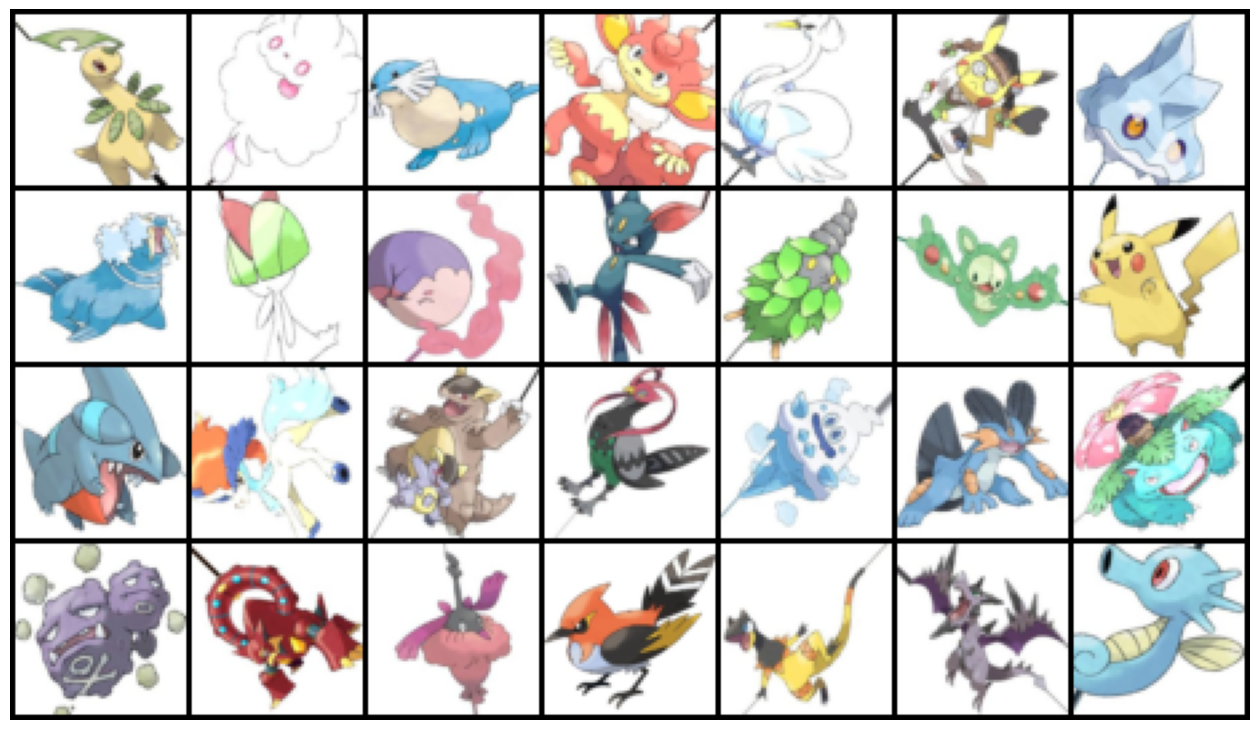

In [10]:
show_images_grid(train_dataloader)

In [11]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,device)
    def __len__(self):
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
train_dataloader = DeviceDataLoader(train_dataloader, device)

### Creating dcgan architecture

In [14]:
discriminator = nn.Sequential(
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    
    nn.Flatten(),
    nn.Sigmoid()
)

In [15]:
discriminator = to_device(discriminator,device)

In [16]:
latent_dim = 128
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_dim,512,kernel_size=4,stride=1,padding=0,bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias = False),
    nn.Tanh()
)

In [17]:
generator = to_device(generator,device)

In [18]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [19]:
def train_generator(opt):
    opt.zero_grad() # clearing gradietns
    latent = torch.randn(batch_size,latent_dim,1,1,device=device)
    fake_images = generator(latent)
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size,1,device = device)
    loss = F.binary_cross_entropy(preds,targets)
    loss.backward()
    opt.step()
    return loss.item()

In [20]:
fixed_latent = torch.randn(64, latent_dim, 1, 1, device=device)

In [23]:
def save_imagesSamp(index, latent_tensors):
    fake_images = generator(latent_tensors)
    fake_fname = 'generatedPokemon-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(image_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)

In [24]:
save_imagesSamp(0, fixed_latent)

Saving generatedPokemon-images-0000.png


In [27]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()   # clearing the cache for working prior gpu
    
    # Losses & scores to be stored in empty tuple lists
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers enforced by adams optimisr, learning rate is 0.0002 for now , gives most stable training
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dataloader):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_imagesSamp(epoch+start_idx, fixed_latent)
    
    return losses_g, losses_d, real_scores, fake_scores

In [28]:
lr = 0.0002 
epochs = 350
history = fit(epochs, lr)

  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [1/350], loss_g: 5.8474, loss_d: 1.1980, real_score: 0.9287, fake_score: 0.6493
Saving generatedPokemon-images-0001.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [2/350], loss_g: 3.1392, loss_d: 0.3156, real_score: 0.8120, fake_score: 0.0807
Saving generatedPokemon-images-0002.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [3/350], loss_g: 1.5879, loss_d: 1.0557, real_score: 0.3998, fake_score: 0.0392
Saving generatedPokemon-images-0003.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [4/350], loss_g: 1.2233, loss_d: 0.9569, real_score: 0.4562, fake_score: 0.0806
Saving generatedPokemon-images-0004.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [5/350], loss_g: 1.3807, loss_d: 1.2304, real_score: 0.3547, fake_score: 0.0254
Saving generatedPokemon-images-0005.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [6/350], loss_g: 2.1568, loss_d: 0.5622, real_score: 0.7111, fake_score: 0.1613
Saving generatedPokemon-images-0006.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [7/350], loss_g: 2.1052, loss_d: 0.6344, real_score: 0.6598, fake_score: 0.1510
Saving generatedPokemon-images-0007.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [8/350], loss_g: 8.1076, loss_d: 1.5709, real_score: 0.9469, fake_score: 0.7481
Saving generatedPokemon-images-0008.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [9/350], loss_g: 2.7682, loss_d: 0.6261, real_score: 0.6093, fake_score: 0.0682
Saving generatedPokemon-images-0009.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [10/350], loss_g: 1.3051, loss_d: 0.8731, real_score: 0.4800, fake_score: 0.0659
Saving generatedPokemon-images-0010.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [11/350], loss_g: 2.8178, loss_d: 0.5667, real_score: 0.8251, fake_score: 0.2769
Saving generatedPokemon-images-0011.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [12/350], loss_g: 1.1266, loss_d: 0.7870, real_score: 0.5324, fake_score: 0.0952
Saving generatedPokemon-images-0012.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [13/350], loss_g: 4.6211, loss_d: 0.6294, real_score: 0.9269, fake_score: 0.3901
Saving generatedPokemon-images-0013.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [14/350], loss_g: 0.6067, loss_d: 1.5226, real_score: 0.2612, fake_score: 0.0349
Saving generatedPokemon-images-0014.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [15/350], loss_g: 2.6521, loss_d: 0.4104, real_score: 0.9050, fake_score: 0.2427
Saving generatedPokemon-images-0015.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [16/350], loss_g: 4.5065, loss_d: 0.8811, real_score: 0.9299, fake_score: 0.5201
Saving generatedPokemon-images-0016.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [17/350], loss_g: 0.8861, loss_d: 0.7734, real_score: 0.5355, fake_score: 0.0839
Saving generatedPokemon-images-0017.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [18/350], loss_g: 2.2221, loss_d: 0.4340, real_score: 0.8142, fake_score: 0.1826
Saving generatedPokemon-images-0018.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [19/350], loss_g: 2.1314, loss_d: 0.4974, real_score: 0.7005, fake_score: 0.1131
Saving generatedPokemon-images-0019.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [20/350], loss_g: 2.2275, loss_d: 0.4878, real_score: 0.7177, fake_score: 0.1086
Saving generatedPokemon-images-0020.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [21/350], loss_g: 3.5754, loss_d: 0.3646, real_score: 0.9339, fake_score: 0.2439
Saving generatedPokemon-images-0021.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [22/350], loss_g: 5.1512, loss_d: 1.1543, real_score: 0.9362, fake_score: 0.6158
Saving generatedPokemon-images-0022.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [23/350], loss_g: 2.8318, loss_d: 0.3884, real_score: 0.8471, fake_score: 0.1830
Saving generatedPokemon-images-0023.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [24/350], loss_g: 2.8821, loss_d: 0.3825, real_score: 0.8238, fake_score: 0.1443
Saving generatedPokemon-images-0024.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [25/350], loss_g: 0.9347, loss_d: 0.7327, real_score: 0.6012, fake_score: 0.1383
Saving generatedPokemon-images-0025.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [26/350], loss_g: 3.1487, loss_d: 0.4394, real_score: 0.8747, fake_score: 0.2278
Saving generatedPokemon-images-0026.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [27/350], loss_g: 2.7373, loss_d: 0.3707, real_score: 0.8888, fake_score: 0.2073
Saving generatedPokemon-images-0027.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [28/350], loss_g: 3.6225, loss_d: 0.5211, real_score: 0.9202, fake_score: 0.3154
Saving generatedPokemon-images-0028.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [29/350], loss_g: 2.9245, loss_d: 0.6001, real_score: 0.8547, fake_score: 0.3242
Saving generatedPokemon-images-0029.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [30/350], loss_g: 3.1151, loss_d: 0.3047, real_score: 0.8611, fake_score: 0.1202
Saving generatedPokemon-images-0030.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [31/350], loss_g: 1.8027, loss_d: 0.4266, real_score: 0.7544, fake_score: 0.1123
Saving generatedPokemon-images-0031.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [32/350], loss_g: 2.9299, loss_d: 0.3955, real_score: 0.8350, fake_score: 0.1613
Saving generatedPokemon-images-0032.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [33/350], loss_g: 4.9153, loss_d: 0.1355, real_score: 0.9792, fake_score: 0.1027
Saving generatedPokemon-images-0033.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [34/350], loss_g: 4.3469, loss_d: 0.4173, real_score: 0.9432, fake_score: 0.2658
Saving generatedPokemon-images-0034.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [35/350], loss_g: 4.0798, loss_d: 0.1885, real_score: 0.9433, fake_score: 0.1148
Saving generatedPokemon-images-0035.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [36/350], loss_g: 2.1507, loss_d: 0.3807, real_score: 0.7620, fake_score: 0.0642
Saving generatedPokemon-images-0036.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [37/350], loss_g: 5.7971, loss_d: 1.6520, real_score: 0.9854, fake_score: 0.7328
Saving generatedPokemon-images-0037.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [38/350], loss_g: 5.5755, loss_d: 0.3580, real_score: 0.9265, fake_score: 0.2149
Saving generatedPokemon-images-0038.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [39/350], loss_g: 4.3855, loss_d: 0.2623, real_score: 0.8788, fake_score: 0.1103
Saving generatedPokemon-images-0039.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [40/350], loss_g: 2.1709, loss_d: 0.2176, real_score: 0.8632, fake_score: 0.0561
Saving generatedPokemon-images-0040.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [41/350], loss_g: 2.2743, loss_d: 0.2475, real_score: 0.8225, fake_score: 0.0288
Saving generatedPokemon-images-0041.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [42/350], loss_g: 2.9527, loss_d: 0.4090, real_score: 0.8573, fake_score: 0.1861
Saving generatedPokemon-images-0042.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [43/350], loss_g: 3.0156, loss_d: 0.1915, real_score: 0.8795, fake_score: 0.0496
Saving generatedPokemon-images-0043.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [44/350], loss_g: 3.4711, loss_d: 0.1128, real_score: 0.9371, fake_score: 0.0425
Saving generatedPokemon-images-0044.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [45/350], loss_g: 2.6479, loss_d: 0.1766, real_score: 0.8895, fake_score: 0.0484
Saving generatedPokemon-images-0045.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [46/350], loss_g: 4.0130, loss_d: 0.1125, real_score: 0.9759, fake_score: 0.0771
Saving generatedPokemon-images-0046.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [47/350], loss_g: 3.7181, loss_d: 0.0892, real_score: 0.9787, fake_score: 0.0628
Saving generatedPokemon-images-0047.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [48/350], loss_g: 4.5986, loss_d: 0.1109, real_score: 0.9408, fake_score: 0.0454
Saving generatedPokemon-images-0048.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [49/350], loss_g: 4.5088, loss_d: 0.2066, real_score: 0.9884, fake_score: 0.1625
Saving generatedPokemon-images-0049.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [50/350], loss_g: 3.8144, loss_d: 0.0981, real_score: 0.9441, fake_score: 0.0362
Saving generatedPokemon-images-0050.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [51/350], loss_g: 3.6265, loss_d: 0.1519, real_score: 0.9281, fake_score: 0.0640
Saving generatedPokemon-images-0051.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [52/350], loss_g: 3.3742, loss_d: 0.1028, real_score: 0.9895, fake_score: 0.0836
Saving generatedPokemon-images-0052.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [53/350], loss_g: 5.3399, loss_d: 0.1051, real_score: 0.9748, fake_score: 0.0709
Saving generatedPokemon-images-0053.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [54/350], loss_g: 4.6644, loss_d: 0.0844, real_score: 0.9466, fake_score: 0.0267
Saving generatedPokemon-images-0054.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [55/350], loss_g: 5.0016, loss_d: 0.4765, real_score: 0.9430, fake_score: 0.2850
Saving generatedPokemon-images-0055.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [56/350], loss_g: 5.0404, loss_d: 1.1125, real_score: 0.9886, fake_score: 0.5663
Saving generatedPokemon-images-0056.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [57/350], loss_g: 6.4285, loss_d: 0.0742, real_score: 0.9918, fake_score: 0.0597
Saving generatedPokemon-images-0057.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [58/350], loss_g: 2.7109, loss_d: 0.1426, real_score: 0.8871, fake_score: 0.0101
Saving generatedPokemon-images-0058.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [59/350], loss_g: 3.0091, loss_d: 0.1759, real_score: 0.8829, fake_score: 0.0389
Saving generatedPokemon-images-0059.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [60/350], loss_g: 4.9089, loss_d: 0.1576, real_score: 0.9095, fake_score: 0.0505
Saving generatedPokemon-images-0060.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [61/350], loss_g: 3.8523, loss_d: 0.0895, real_score: 0.9456, fake_score: 0.0302
Saving generatedPokemon-images-0061.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [62/350], loss_g: 2.4807, loss_d: 0.1742, real_score: 0.9045, fake_score: 0.0639
Saving generatedPokemon-images-0062.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [63/350], loss_g: 0.0536, loss_d: 0.9169, real_score: 0.4736, fake_score: 0.0112
Saving generatedPokemon-images-0063.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [64/350], loss_g: 4.5152, loss_d: 0.1070, real_score: 0.9701, fake_score: 0.0676
Saving generatedPokemon-images-0064.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [65/350], loss_g: 7.4075, loss_d: 0.2570, real_score: 0.9854, fake_score: 0.1916
Saving generatedPokemon-images-0065.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [66/350], loss_g: 4.6272, loss_d: 0.0856, real_score: 0.9824, fake_score: 0.0630
Saving generatedPokemon-images-0066.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [67/350], loss_g: 3.3321, loss_d: 0.1717, real_score: 0.9418, fake_score: 0.0947
Saving generatedPokemon-images-0067.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [68/350], loss_g: 1.8453, loss_d: 0.3156, real_score: 0.7596, fake_score: 0.0185
Saving generatedPokemon-images-0068.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [69/350], loss_g: 4.8132, loss_d: 0.0915, real_score: 0.9971, fake_score: 0.0788
Saving generatedPokemon-images-0069.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [70/350], loss_g: 2.9886, loss_d: 0.2984, real_score: 0.9145, fake_score: 0.1593
Saving generatedPokemon-images-0070.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [71/350], loss_g: 5.5023, loss_d: 0.0496, real_score: 0.9572, fake_score: 0.0048
Saving generatedPokemon-images-0071.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [72/350], loss_g: 4.9366, loss_d: 0.0627, real_score: 0.9780, fake_score: 0.0384
Saving generatedPokemon-images-0072.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [73/350], loss_g: 4.3839, loss_d: 0.0625, real_score: 0.9548, fake_score: 0.0135
Saving generatedPokemon-images-0073.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [74/350], loss_g: 4.4014, loss_d: 0.1062, real_score: 0.9107, fake_score: 0.0050
Saving generatedPokemon-images-0074.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [75/350], loss_g: 3.9721, loss_d: 0.0765, real_score: 0.9444, fake_score: 0.0171
Saving generatedPokemon-images-0075.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [76/350], loss_g: 4.6876, loss_d: 0.0658, real_score: 0.9674, fake_score: 0.0307
Saving generatedPokemon-images-0076.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [77/350], loss_g: 1.7075, loss_d: 0.6058, real_score: 0.7268, fake_score: 0.1450
Saving generatedPokemon-images-0077.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [78/350], loss_g: 3.4170, loss_d: 0.1032, real_score: 0.9421, fake_score: 0.0405
Saving generatedPokemon-images-0078.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [79/350], loss_g: 4.0887, loss_d: 0.1307, real_score: 0.9836, fake_score: 0.0985
Saving generatedPokemon-images-0079.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [80/350], loss_g: 4.5349, loss_d: 0.0892, real_score: 0.9287, fake_score: 0.0106
Saving generatedPokemon-images-0080.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [81/350], loss_g: 2.5580, loss_d: 0.2511, real_score: 0.8095, fake_score: 0.0134
Saving generatedPokemon-images-0081.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [82/350], loss_g: 4.4270, loss_d: 0.2369, real_score: 0.9669, fake_score: 0.1606
Saving generatedPokemon-images-0082.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [83/350], loss_g: 3.9310, loss_d: 0.1573, real_score: 0.9899, fake_score: 0.1211
Saving generatedPokemon-images-0083.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [84/350], loss_g: 5.0822, loss_d: 0.0278, real_score: 0.9834, fake_score: 0.0105
Saving generatedPokemon-images-0084.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [85/350], loss_g: 3.8216, loss_d: 0.0713, real_score: 0.9453, fake_score: 0.0110
Saving generatedPokemon-images-0085.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [86/350], loss_g: 6.2406, loss_d: 0.4908, real_score: 0.9964, fake_score: 0.3346
Saving generatedPokemon-images-0086.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [87/350], loss_g: 6.5696, loss_d: 0.0960, real_score: 0.9602, fake_score: 0.0502
Saving generatedPokemon-images-0087.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [88/350], loss_g: 5.3463, loss_d: 0.0830, real_score: 0.9269, fake_score: 0.0020
Saving generatedPokemon-images-0088.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [89/350], loss_g: 2.8289, loss_d: 0.2110, real_score: 0.8595, fake_score: 0.0334
Saving generatedPokemon-images-0089.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [90/350], loss_g: 6.2643, loss_d: 0.0167, real_score: 0.9940, fake_score: 0.0106
Saving generatedPokemon-images-0090.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [91/350], loss_g: 2.5472, loss_d: 0.2775, real_score: 0.8776, fake_score: 0.0896
Saving generatedPokemon-images-0091.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [92/350], loss_g: 2.9443, loss_d: 0.1444, real_score: 0.8822, fake_score: 0.0089
Saving generatedPokemon-images-0092.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [93/350], loss_g: 4.6920, loss_d: 0.0674, real_score: 0.9725, fake_score: 0.0363
Saving generatedPokemon-images-0093.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [94/350], loss_g: 5.8141, loss_d: 0.0118, real_score: 0.9969, fake_score: 0.0086
Saving generatedPokemon-images-0094.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [95/350], loss_g: 5.6026, loss_d: 0.0392, real_score: 0.9994, fake_score: 0.0365
Saving generatedPokemon-images-0095.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [96/350], loss_g: 6.0304, loss_d: 0.0087, real_score: 0.9996, fake_score: 0.0082
Saving generatedPokemon-images-0096.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [97/350], loss_g: 2.2141, loss_d: 0.1814, real_score: 0.9073, fake_score: 0.0694
Saving generatedPokemon-images-0097.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [98/350], loss_g: 4.5509, loss_d: 0.1355, real_score: 0.9234, fake_score: 0.0430
Saving generatedPokemon-images-0098.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [99/350], loss_g: 5.1056, loss_d: 0.0400, real_score: 0.9812, fake_score: 0.0197
Saving generatedPokemon-images-0099.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [100/350], loss_g: 6.2565, loss_d: 0.0188, real_score: 0.9963, fake_score: 0.0147
Saving generatedPokemon-images-0100.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [101/350], loss_g: 4.6325, loss_d: 0.0640, real_score: 0.9777, fake_score: 0.0373
Saving generatedPokemon-images-0101.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [102/350], loss_g: 5.2538, loss_d: 0.0229, real_score: 0.9901, fake_score: 0.0127
Saving generatedPokemon-images-0102.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [103/350], loss_g: 2.9526, loss_d: 3.8437, real_score: 0.0442, fake_score: 0.0000
Saving generatedPokemon-images-0103.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [104/350], loss_g: 4.6311, loss_d: 0.0540, real_score: 0.9822, fake_score: 0.0333
Saving generatedPokemon-images-0104.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [105/350], loss_g: 0.8761, loss_d: 5.3516, real_score: 0.0165, fake_score: 0.0001
Saving generatedPokemon-images-0105.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [106/350], loss_g: 5.0390, loss_d: 0.0677, real_score: 0.9942, fake_score: 0.0562
Saving generatedPokemon-images-0106.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [107/350], loss_g: 7.7263, loss_d: 0.0176, real_score: 0.9877, fake_score: 0.0051
Saving generatedPokemon-images-0107.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [108/350], loss_g: 6.5848, loss_d: 0.0187, real_score: 0.9869, fake_score: 0.0053
Saving generatedPokemon-images-0108.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [109/350], loss_g: 5.5995, loss_d: 0.0276, real_score: 0.9955, fake_score: 0.0223
Saving generatedPokemon-images-0109.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [110/350], loss_g: 4.7838, loss_d: 0.1023, real_score: 0.9834, fake_score: 0.0598
Saving generatedPokemon-images-0110.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [111/350], loss_g: 5.1942, loss_d: 0.0450, real_score: 0.9893, fake_score: 0.0327
Saving generatedPokemon-images-0111.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [112/350], loss_g: 4.1197, loss_d: 0.0652, real_score: 0.9670, fake_score: 0.0293
Saving generatedPokemon-images-0112.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [113/350], loss_g: 4.8663, loss_d: 0.0694, real_score: 0.9459, fake_score: 0.0110
Saving generatedPokemon-images-0113.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [114/350], loss_g: 5.0775, loss_d: 0.0176, real_score: 0.9971, fake_score: 0.0142
Saving generatedPokemon-images-0114.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [115/350], loss_g: 4.9556, loss_d: 0.4863, real_score: 0.9928, fake_score: 0.3004
Saving generatedPokemon-images-0115.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [116/350], loss_g: 6.3121, loss_d: 0.1113, real_score: 0.9873, fake_score: 0.0815
Saving generatedPokemon-images-0116.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [117/350], loss_g: 4.2552, loss_d: 0.0289, real_score: 0.9830, fake_score: 0.0109
Saving generatedPokemon-images-0117.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [118/350], loss_g: 5.5881, loss_d: 0.0155, real_score: 0.9895, fake_score: 0.0049
Saving generatedPokemon-images-0118.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [119/350], loss_g: 4.8710, loss_d: 0.0497, real_score: 0.9578, fake_score: 0.0048
Saving generatedPokemon-images-0119.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [120/350], loss_g: 5.5035, loss_d: 0.1973, real_score: 0.8457, fake_score: 0.0019
Saving generatedPokemon-images-0120.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [121/350], loss_g: 4.8073, loss_d: 0.0740, real_score: 0.9998, fake_score: 0.0620
Saving generatedPokemon-images-0121.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [122/350], loss_g: 5.0710, loss_d: 0.0095, real_score: 0.9981, fake_score: 0.0075
Saving generatedPokemon-images-0122.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [123/350], loss_g: 7.0637, loss_d: 0.0151, real_score: 0.9901, fake_score: 0.0050
Saving generatedPokemon-images-0123.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [124/350], loss_g: 3.9157, loss_d: 0.2526, real_score: 0.9992, fake_score: 0.1789
Saving generatedPokemon-images-0124.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [125/350], loss_g: 5.9891, loss_d: 0.0236, real_score: 0.9792, fake_score: 0.0022
Saving generatedPokemon-images-0125.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [126/350], loss_g: 2.9076, loss_d: 0.7277, real_score: 0.9794, fake_score: 0.4000
Saving generatedPokemon-images-0126.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [127/350], loss_g: 5.8749, loss_d: 0.0276, real_score: 0.9827, fake_score: 0.0096
Saving generatedPokemon-images-0127.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [128/350], loss_g: 5.8000, loss_d: 0.0329, real_score: 0.9726, fake_score: 0.0044
Saving generatedPokemon-images-0128.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [129/350], loss_g: 6.6320, loss_d: 0.0270, real_score: 0.9988, fake_score: 0.0250
Saving generatedPokemon-images-0129.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [130/350], loss_g: 4.0296, loss_d: 0.1248, real_score: 0.9937, fake_score: 0.0962
Saving generatedPokemon-images-0130.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [131/350], loss_g: 6.0059, loss_d: 0.0367, real_score: 0.9884, fake_score: 0.0232
Saving generatedPokemon-images-0131.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [132/350], loss_g: 7.4287, loss_d: 0.0078, real_score: 0.9975, fake_score: 0.0052
Saving generatedPokemon-images-0132.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [133/350], loss_g: 5.9683, loss_d: 0.1374, real_score: 0.9980, fake_score: 0.1043
Saving generatedPokemon-images-0133.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [134/350], loss_g: 3.5469, loss_d: 0.1833, real_score: 0.8814, fake_score: 0.0353
Saving generatedPokemon-images-0134.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [135/350], loss_g: 2.3720, loss_d: 0.8626, real_score: 0.5133, fake_score: 0.0137
Saving generatedPokemon-images-0135.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [136/350], loss_g: 4.6541, loss_d: 0.1123, real_score: 0.9824, fake_score: 0.0684
Saving generatedPokemon-images-0136.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [137/350], loss_g: 4.7324, loss_d: 0.0421, real_score: 0.9832, fake_score: 0.0242
Saving generatedPokemon-images-0137.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [138/350], loss_g: 5.0809, loss_d: 0.0231, real_score: 0.9953, fake_score: 0.0176
Saving generatedPokemon-images-0138.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [139/350], loss_g: 2.9675, loss_d: 0.0888, real_score: 0.9354, fake_score: 0.0176
Saving generatedPokemon-images-0139.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [140/350], loss_g: 4.9761, loss_d: 0.0627, real_score: 0.9997, fake_score: 0.0558
Saving generatedPokemon-images-0140.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [141/350], loss_g: 8.1405, loss_d: 0.0060, real_score: 0.9959, fake_score: 0.0018
Saving generatedPokemon-images-0141.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [142/350], loss_g: 5.4248, loss_d: 0.0309, real_score: 0.9743, fake_score: 0.0045
Saving generatedPokemon-images-0142.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [143/350], loss_g: 2.1198, loss_d: 0.3785, real_score: 0.7563, fake_score: 0.0396
Saving generatedPokemon-images-0143.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [144/350], loss_g: 4.8146, loss_d: 0.0780, real_score: 0.9464, fake_score: 0.0180
Saving generatedPokemon-images-0144.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [145/350], loss_g: 4.1690, loss_d: 0.2936, real_score: 0.8032, fake_score: 0.0192
Saving generatedPokemon-images-0145.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [146/350], loss_g: 4.9615, loss_d: 0.0669, real_score: 0.9673, fake_score: 0.0284
Saving generatedPokemon-images-0146.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [147/350], loss_g: 5.1178, loss_d: 0.0617, real_score: 0.9952, fake_score: 0.0515
Saving generatedPokemon-images-0147.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [148/350], loss_g: 5.3189, loss_d: 0.0605, real_score: 0.9753, fake_score: 0.0327
Saving generatedPokemon-images-0148.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [149/350], loss_g: 6.7336, loss_d: 0.0237, real_score: 0.9923, fake_score: 0.0150
Saving generatedPokemon-images-0149.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [150/350], loss_g: 4.7346, loss_d: 0.0326, real_score: 0.9782, fake_score: 0.0102
Saving generatedPokemon-images-0150.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [151/350], loss_g: 7.8366, loss_d: 0.0134, real_score: 0.9941, fake_score: 0.0073
Saving generatedPokemon-images-0151.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [152/350], loss_g: 5.4067, loss_d: 0.0354, real_score: 0.9699, fake_score: 0.0043
Saving generatedPokemon-images-0152.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [153/350], loss_g: 6.5156, loss_d: 0.0133, real_score: 0.9890, fake_score: 0.0016
Saving generatedPokemon-images-0153.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [154/350], loss_g: 7.0648, loss_d: 0.0328, real_score: 0.9879, fake_score: 0.0194
Saving generatedPokemon-images-0154.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [155/350], loss_g: 6.7275, loss_d: 0.0063, real_score: 0.9988, fake_score: 0.0050
Saving generatedPokemon-images-0155.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [156/350], loss_g: 3.5269, loss_d: 0.1960, real_score: 0.9124, fake_score: 0.0795
Saving generatedPokemon-images-0156.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [157/350], loss_g: 4.1455, loss_d: 0.1459, real_score: 0.9567, fake_score: 0.0836
Saving generatedPokemon-images-0157.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [158/350], loss_g: 4.4053, loss_d: 0.0834, real_score: 0.9527, fake_score: 0.0316
Saving generatedPokemon-images-0158.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [159/350], loss_g: 7.1979, loss_d: 0.0070, real_score: 0.9981, fake_score: 0.0051
Saving generatedPokemon-images-0159.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [160/350], loss_g: 5.2486, loss_d: 0.0421, real_score: 0.9927, fake_score: 0.0323
Saving generatedPokemon-images-0160.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [161/350], loss_g: 4.5729, loss_d: 0.0822, real_score: 0.9506, fake_score: 0.0171
Saving generatedPokemon-images-0161.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [162/350], loss_g: 4.9075, loss_d: 0.0646, real_score: 0.9672, fake_score: 0.0271
Saving generatedPokemon-images-0162.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [163/350], loss_g: 5.1752, loss_d: 0.0562, real_score: 0.9714, fake_score: 0.0243
Saving generatedPokemon-images-0163.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [164/350], loss_g: 0.8748, loss_d: 0.2912, real_score: 0.7863, fake_score: 0.0014
Saving generatedPokemon-images-0164.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [165/350], loss_g: 5.5309, loss_d: 0.0161, real_score: 0.9988, fake_score: 0.0146
Saving generatedPokemon-images-0165.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [166/350], loss_g: 6.0486, loss_d: 0.0051, real_score: 0.9976, fake_score: 0.0027
Saving generatedPokemon-images-0166.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [167/350], loss_g: 7.0024, loss_d: 0.0177, real_score: 0.9931, fake_score: 0.0103
Saving generatedPokemon-images-0167.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [168/350], loss_g: 6.0840, loss_d: 0.0962, real_score: 0.9950, fake_score: 0.0817
Saving generatedPokemon-images-0168.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [169/350], loss_g: 3.0105, loss_d: 0.4235, real_score: 0.7386, fake_score: 0.0200
Saving generatedPokemon-images-0169.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [170/350], loss_g: 4.9536, loss_d: 0.0184, real_score: 0.9926, fake_score: 0.0108
Saving generatedPokemon-images-0170.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [171/350], loss_g: 7.0152, loss_d: 0.0095, real_score: 0.9973, fake_score: 0.0068
Saving generatedPokemon-images-0171.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [172/350], loss_g: 5.9107, loss_d: 0.0167, real_score: 0.9864, fake_score: 0.0029
Saving generatedPokemon-images-0172.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [173/350], loss_g: 6.7596, loss_d: 0.0159, real_score: 0.9963, fake_score: 0.0120
Saving generatedPokemon-images-0173.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [174/350], loss_g: 1.9880, loss_d: 0.8661, real_score: 0.5457, fake_score: 0.0097
Saving generatedPokemon-images-0174.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [175/350], loss_g: 4.0454, loss_d: 0.1944, real_score: 0.8922, fake_score: 0.0479
Saving generatedPokemon-images-0175.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [176/350], loss_g: 3.0233, loss_d: 0.7958, real_score: 0.7714, fake_score: 0.2743
Saving generatedPokemon-images-0176.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [177/350], loss_g: 4.6526, loss_d: 0.0542, real_score: 0.9627, fake_score: 0.0143
Saving generatedPokemon-images-0177.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [178/350], loss_g: 3.8441, loss_d: 0.1146, real_score: 0.9069, fake_score: 0.0081
Saving generatedPokemon-images-0178.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [179/350], loss_g: 6.6694, loss_d: 0.0152, real_score: 0.9879, fake_score: 0.0029
Saving generatedPokemon-images-0179.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [180/350], loss_g: 5.7006, loss_d: 0.0624, real_score: 0.9948, fake_score: 0.0527
Saving generatedPokemon-images-0180.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [181/350], loss_g: 6.4114, loss_d: 0.0215, real_score: 0.9831, fake_score: 0.0039
Saving generatedPokemon-images-0181.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [182/350], loss_g: 14.5520, loss_d: 6.0051, real_score: 1.0000, fake_score: 0.9855
Saving generatedPokemon-images-0182.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [183/350], loss_g: 6.3651, loss_d: 0.0179, real_score: 0.9943, fake_score: 0.0118
Saving generatedPokemon-images-0183.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [184/350], loss_g: 5.5518, loss_d: 0.0098, real_score: 0.9968, fake_score: 0.0065
Saving generatedPokemon-images-0184.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [185/350], loss_g: 5.4724, loss_d: 0.0144, real_score: 0.9902, fake_score: 0.0045
Saving generatedPokemon-images-0185.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [186/350], loss_g: 3.8590, loss_d: 0.1160, real_score: 0.9511, fake_score: 0.0562
Saving generatedPokemon-images-0186.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [187/350], loss_g: 5.4317, loss_d: 0.0449, real_score: 0.9666, fake_score: 0.0098
Saving generatedPokemon-images-0187.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [188/350], loss_g: 5.3217, loss_d: 0.0178, real_score: 0.9976, fake_score: 0.0144
Saving generatedPokemon-images-0188.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [189/350], loss_g: 6.2668, loss_d: 0.0362, real_score: 0.9914, fake_score: 0.0257
Saving generatedPokemon-images-0189.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [190/350], loss_g: 6.2351, loss_d: 0.0131, real_score: 0.9942, fake_score: 0.0072
Saving generatedPokemon-images-0190.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [191/350], loss_g: 5.3435, loss_d: 0.0371, real_score: 0.9676, fake_score: 0.0025
Saving generatedPokemon-images-0191.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [192/350], loss_g: 3.7006, loss_d: 0.0638, real_score: 0.9423, fake_score: 0.0030
Saving generatedPokemon-images-0192.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [193/350], loss_g: 5.3971, loss_d: 0.0291, real_score: 0.9880, fake_score: 0.0164
Saving generatedPokemon-images-0193.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [194/350], loss_g: 5.8098, loss_d: 0.0160, real_score: 0.9961, fake_score: 0.0120
Saving generatedPokemon-images-0194.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [195/350], loss_g: 2.8672, loss_d: 1.3481, real_score: 0.4484, fake_score: 0.0051
Saving generatedPokemon-images-0195.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [196/350], loss_g: 5.3683, loss_d: 0.0274, real_score: 0.9845, fake_score: 0.0113
Saving generatedPokemon-images-0196.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [197/350], loss_g: 3.6358, loss_d: 0.1134, real_score: 0.9854, fake_score: 0.0861
Saving generatedPokemon-images-0197.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [198/350], loss_g: 4.6972, loss_d: 0.0490, real_score: 0.9756, fake_score: 0.0214
Saving generatedPokemon-images-0198.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [199/350], loss_g: 5.7825, loss_d: 0.0188, real_score: 0.9984, fake_score: 0.0164
Saving generatedPokemon-images-0199.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [200/350], loss_g: 6.2253, loss_d: 0.0152, real_score: 0.9985, fake_score: 0.0133
Saving generatedPokemon-images-0200.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [201/350], loss_g: 7.2498, loss_d: 0.0181, real_score: 0.9877, fake_score: 0.0054
Saving generatedPokemon-images-0201.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [202/350], loss_g: 3.6653, loss_d: 0.2946, real_score: 0.8174, fake_score: 0.0540
Saving generatedPokemon-images-0202.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [203/350], loss_g: 6.7029, loss_d: 0.0174, real_score: 0.9893, fake_score: 0.0064
Saving generatedPokemon-images-0203.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [204/350], loss_g: 6.4005, loss_d: 0.0748, real_score: 0.9940, fake_score: 0.0601
Saving generatedPokemon-images-0204.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [205/350], loss_g: 3.9889, loss_d: 0.1030, real_score: 0.9242, fake_score: 0.0169
Saving generatedPokemon-images-0205.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [206/350], loss_g: 3.6510, loss_d: 0.1340, real_score: 0.8848, fake_score: 0.0023
Saving generatedPokemon-images-0206.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [207/350], loss_g: 6.1389, loss_d: 0.0092, real_score: 0.9966, fake_score: 0.0057
Saving generatedPokemon-images-0207.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [208/350], loss_g: 5.7671, loss_d: 0.0124, real_score: 0.9923, fake_score: 0.0046
Saving generatedPokemon-images-0208.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [209/350], loss_g: 6.0861, loss_d: 0.0996, real_score: 0.9729, fake_score: 0.0531
Saving generatedPokemon-images-0209.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [210/350], loss_g: 4.0931, loss_d: 0.0889, real_score: 0.9516, fake_score: 0.0310
Saving generatedPokemon-images-0210.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [211/350], loss_g: 5.3165, loss_d: 0.0285, real_score: 0.9813, fake_score: 0.0088
Saving generatedPokemon-images-0211.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [212/350], loss_g: 5.4441, loss_d: 0.1763, real_score: 0.9521, fake_score: 0.0662
Saving generatedPokemon-images-0212.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [213/350], loss_g: 6.2996, loss_d: 0.0042, real_score: 0.9990, fake_score: 0.0031
Saving generatedPokemon-images-0213.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [214/350], loss_g: 10.1042, loss_d: 0.0122, real_score: 0.9892, fake_score: 0.0013
Saving generatedPokemon-images-0214.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [215/350], loss_g: 5.5936, loss_d: 0.0065, real_score: 0.9958, fake_score: 0.0023
Saving generatedPokemon-images-0215.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [216/350], loss_g: 7.5365, loss_d: 0.0053, real_score: 0.9976, fake_score: 0.0029
Saving generatedPokemon-images-0216.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [217/350], loss_g: 4.2040, loss_d: 0.1793, real_score: 0.9005, fake_score: 0.0429
Saving generatedPokemon-images-0217.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [218/350], loss_g: 0.9974, loss_d: 0.1195, real_score: 0.9368, fake_score: 0.0453
Saving generatedPokemon-images-0218.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [219/350], loss_g: 6.4520, loss_d: 0.0092, real_score: 0.9931, fake_score: 0.0022
Saving generatedPokemon-images-0219.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [220/350], loss_g: 5.0077, loss_d: 0.0603, real_score: 0.9727, fake_score: 0.0244
Saving generatedPokemon-images-0220.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [221/350], loss_g: 5.2250, loss_d: 0.0991, real_score: 0.9551, fake_score: 0.0273
Saving generatedPokemon-images-0221.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [222/350], loss_g: 6.6713, loss_d: 0.0154, real_score: 0.9993, fake_score: 0.0139
Saving generatedPokemon-images-0222.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [223/350], loss_g: 5.4557, loss_d: 0.2653, real_score: 0.9414, fake_score: 0.1460
Saving generatedPokemon-images-0223.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [224/350], loss_g: 5.5104, loss_d: 0.0377, real_score: 0.9898, fake_score: 0.0256
Saving generatedPokemon-images-0224.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [225/350], loss_g: 5.4906, loss_d: 0.0232, real_score: 0.9996, fake_score: 0.0210
Saving generatedPokemon-images-0225.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [226/350], loss_g: 7.2423, loss_d: 0.0079, real_score: 0.9950, fake_score: 0.0028
Saving generatedPokemon-images-0226.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [227/350], loss_g: 5.3884, loss_d: 0.0543, real_score: 0.9634, fake_score: 0.0144
Saving generatedPokemon-images-0227.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [228/350], loss_g: 1.7823, loss_d: 0.1397, real_score: 0.8902, fake_score: 0.0027
Saving generatedPokemon-images-0228.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [229/350], loss_g: 4.0903, loss_d: 0.0568, real_score: 0.9492, fake_score: 0.0028
Saving generatedPokemon-images-0229.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [230/350], loss_g: 5.1601, loss_d: 0.0865, real_score: 0.9662, fake_score: 0.0389
Saving generatedPokemon-images-0230.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [231/350], loss_g: 4.7287, loss_d: 0.0414, real_score: 0.9668, fake_score: 0.0045
Saving generatedPokemon-images-0231.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [232/350], loss_g: 3.9762, loss_d: 0.0389, real_score: 0.9878, fake_score: 0.0248
Saving generatedPokemon-images-0232.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [233/350], loss_g: 6.1371, loss_d: 0.0181, real_score: 0.9925, fake_score: 0.0101
Saving generatedPokemon-images-0233.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [234/350], loss_g: 2.8488, loss_d: 0.1169, real_score: 0.9046, fake_score: 0.0011
Saving generatedPokemon-images-0234.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [235/350], loss_g: 7.3491, loss_d: 0.0056, real_score: 0.9992, fake_score: 0.0048
Saving generatedPokemon-images-0235.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [236/350], loss_g: 6.6724, loss_d: 0.0130, real_score: 0.9885, fake_score: 0.0013
Saving generatedPokemon-images-0236.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [237/350], loss_g: 6.4814, loss_d: 0.0913, real_score: 0.9875, fake_score: 0.0643
Saving generatedPokemon-images-0237.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [238/350], loss_g: 5.2613, loss_d: 0.0943, real_score: 0.9998, fake_score: 0.0736
Saving generatedPokemon-images-0238.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [239/350], loss_g: 0.6069, loss_d: 0.5866, real_score: 0.6352, fake_score: 0.0032
Saving generatedPokemon-images-0239.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [240/350], loss_g: 5.3349, loss_d: 0.0458, real_score: 0.9608, fake_score: 0.0038
Saving generatedPokemon-images-0240.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [241/350], loss_g: 6.8357, loss_d: 0.0142, real_score: 0.9962, fake_score: 0.0099
Saving generatedPokemon-images-0241.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [242/350], loss_g: 6.9032, loss_d: 0.0117, real_score: 0.9972, fake_score: 0.0087
Saving generatedPokemon-images-0242.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [243/350], loss_g: 6.7052, loss_d: 0.0106, real_score: 0.9900, fake_score: 0.0004
Saving generatedPokemon-images-0243.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [244/350], loss_g: 5.6463, loss_d: 0.0101, real_score: 0.9925, fake_score: 0.0025
Saving generatedPokemon-images-0244.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [245/350], loss_g: 4.6427, loss_d: 0.0278, real_score: 0.9995, fake_score: 0.0256
Saving generatedPokemon-images-0245.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [246/350], loss_g: 6.2629, loss_d: 0.0033, real_score: 0.9992, fake_score: 0.0025
Saving generatedPokemon-images-0246.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [247/350], loss_g: 6.5087, loss_d: 0.0102, real_score: 0.9922, fake_score: 0.0023
Saving generatedPokemon-images-0247.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [248/350], loss_g: 4.7178, loss_d: 0.4595, real_score: 0.9198, fake_score: 0.2535
Saving generatedPokemon-images-0248.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [249/350], loss_g: 4.8103, loss_d: 0.0596, real_score: 0.9916, fake_score: 0.0457
Saving generatedPokemon-images-0249.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [250/350], loss_g: 6.0731, loss_d: 0.0143, real_score: 0.9984, fake_score: 0.0117
Saving generatedPokemon-images-0250.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [251/350], loss_g: 5.1949, loss_d: 0.0528, real_score: 0.9588, fake_score: 0.0064
Saving generatedPokemon-images-0251.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [252/350], loss_g: 5.1053, loss_d: 0.0188, real_score: 0.9984, fake_score: 0.0166
Saving generatedPokemon-images-0252.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [253/350], loss_g: 6.4513, loss_d: 0.0183, real_score: 0.9946, fake_score: 0.0125
Saving generatedPokemon-images-0253.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [254/350], loss_g: 4.5596, loss_d: 0.0554, real_score: 0.9564, fake_score: 0.0066
Saving generatedPokemon-images-0254.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [255/350], loss_g: 6.0270, loss_d: 0.0096, real_score: 0.9948, fake_score: 0.0043
Saving generatedPokemon-images-0255.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [256/350], loss_g: 5.4552, loss_d: 0.0381, real_score: 0.9754, fake_score: 0.0121
Saving generatedPokemon-images-0256.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [257/350], loss_g: 9.4521, loss_d: 0.0260, real_score: 0.9759, fake_score: 0.0006
Saving generatedPokemon-images-0257.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [258/350], loss_g: 7.3753, loss_d: 0.0067, real_score: 0.9992, fake_score: 0.0059
Saving generatedPokemon-images-0258.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [259/350], loss_g: 7.9674, loss_d: 0.0037, real_score: 0.9972, fake_score: 0.0008
Saving generatedPokemon-images-0259.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [260/350], loss_g: 7.4487, loss_d: 0.0061, real_score: 0.9952, fake_score: 0.0012
Saving generatedPokemon-images-0260.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [261/350], loss_g: 5.5208, loss_d: 0.0314, real_score: 0.9975, fake_score: 0.0259
Saving generatedPokemon-images-0261.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [262/350], loss_g: 7.2846, loss_d: 0.0651, real_score: 0.9429, fake_score: 0.0008
Saving generatedPokemon-images-0262.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [263/350], loss_g: 4.8244, loss_d: 0.0701, real_score: 0.9442, fake_score: 0.0033
Saving generatedPokemon-images-0263.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [264/350], loss_g: 5.1168, loss_d: 0.0570, real_score: 0.9517, fake_score: 0.0056
Saving generatedPokemon-images-0264.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [265/350], loss_g: 2.9048, loss_d: 0.3584, real_score: 0.8065, fake_score: 0.0807
Saving generatedPokemon-images-0265.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [266/350], loss_g: 3.9354, loss_d: 0.1239, real_score: 0.9971, fake_score: 0.1048
Saving generatedPokemon-images-0266.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [267/350], loss_g: 5.1608, loss_d: 0.0101, real_score: 0.9984, fake_score: 0.0083
Saving generatedPokemon-images-0267.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [268/350], loss_g: 6.4755, loss_d: 0.0196, real_score: 0.9964, fake_score: 0.0154
Saving generatedPokemon-images-0268.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [269/350], loss_g: 5.1673, loss_d: 0.0105, real_score: 0.9977, fake_score: 0.0081
Saving generatedPokemon-images-0269.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [270/350], loss_g: 7.8709, loss_d: 0.0742, real_score: 0.9347, fake_score: 0.0001
Saving generatedPokemon-images-0270.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [271/350], loss_g: 5.7111, loss_d: 0.0108, real_score: 0.9997, fake_score: 0.0104
Saving generatedPokemon-images-0271.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [272/350], loss_g: 11.8578, loss_d: 0.0018, real_score: 0.9983, fake_score: 0.0000
Saving generatedPokemon-images-0272.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [273/350], loss_g: 2.3966, loss_d: 0.5822, real_score: 0.7894, fake_score: 0.1728
Saving generatedPokemon-images-0273.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [274/350], loss_g: 7.7480, loss_d: 0.0439, real_score: 0.9677, fake_score: 0.0087
Saving generatedPokemon-images-0274.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [275/350], loss_g: 6.5439, loss_d: 0.0161, real_score: 0.9966, fake_score: 0.0123
Saving generatedPokemon-images-0275.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [276/350], loss_g: 6.5471, loss_d: 0.0253, real_score: 0.9970, fake_score: 0.0213
Saving generatedPokemon-images-0276.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [277/350], loss_g: 5.8123, loss_d: 0.0145, real_score: 0.9978, fake_score: 0.0119
Saving generatedPokemon-images-0277.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [278/350], loss_g: 6.7190, loss_d: 0.0236, real_score: 0.9807, fake_score: 0.0035
Saving generatedPokemon-images-0278.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [279/350], loss_g: 7.2777, loss_d: 0.0044, real_score: 0.9994, fake_score: 0.0037
Saving generatedPokemon-images-0279.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [280/350], loss_g: 6.7495, loss_d: 0.0215, real_score: 0.9826, fake_score: 0.0022
Saving generatedPokemon-images-0280.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [281/350], loss_g: 4.7708, loss_d: 0.0379, real_score: 0.9727, fake_score: 0.0089
Saving generatedPokemon-images-0281.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [282/350], loss_g: 7.0384, loss_d: 0.1921, real_score: 0.9980, fake_score: 0.1440
Saving generatedPokemon-images-0282.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [283/350], loss_g: 6.2958, loss_d: 0.0427, real_score: 0.9890, fake_score: 0.0281
Saving generatedPokemon-images-0283.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [284/350], loss_g: 3.5688, loss_d: 0.0510, real_score: 0.9582, fake_score: 0.0055
Saving generatedPokemon-images-0284.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [285/350], loss_g: 9.1181, loss_d: 0.2370, real_score: 0.9998, fake_score: 0.1713
Saving generatedPokemon-images-0285.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [286/350], loss_g: 3.2595, loss_d: 0.2790, real_score: 0.8589, fake_score: 0.0700
Saving generatedPokemon-images-0286.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [287/350], loss_g: 5.4330, loss_d: 0.0434, real_score: 0.9636, fake_score: 0.0018
Saving generatedPokemon-images-0287.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [288/350], loss_g: 6.1249, loss_d: 0.0105, real_score: 0.9988, fake_score: 0.0090
Saving generatedPokemon-images-0288.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [289/350], loss_g: 9.6417, loss_d: 2.0146, real_score: 0.9999, fake_score: 0.7290
Saving generatedPokemon-images-0289.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [290/350], loss_g: 6.4626, loss_d: 0.0209, real_score: 0.9843, fake_score: 0.0046
Saving generatedPokemon-images-0290.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [291/350], loss_g: 6.5501, loss_d: 0.0221, real_score: 0.9799, fake_score: 0.0011
Saving generatedPokemon-images-0291.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [292/350], loss_g: 7.4479, loss_d: 0.0022, real_score: 0.9998, fake_score: 0.0021
Saving generatedPokemon-images-0292.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [293/350], loss_g: 6.8203, loss_d: 0.0035, real_score: 0.9995, fake_score: 0.0029
Saving generatedPokemon-images-0293.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [294/350], loss_g: 7.0963, loss_d: 0.0119, real_score: 0.9907, fake_score: 0.0024
Saving generatedPokemon-images-0294.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [295/350], loss_g: 7.5610, loss_d: 0.0056, real_score: 0.9966, fake_score: 0.0021
Saving generatedPokemon-images-0295.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [296/350], loss_g: 8.6684, loss_d: 0.0051, real_score: 0.9967, fake_score: 0.0018
Saving generatedPokemon-images-0296.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [297/350], loss_g: 3.3155, loss_d: 0.6309, real_score: 0.6816, fake_score: 0.0234
Saving generatedPokemon-images-0297.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [298/350], loss_g: 6.4964, loss_d: 0.0458, real_score: 0.9782, fake_score: 0.0188
Saving generatedPokemon-images-0298.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [299/350], loss_g: 5.3108, loss_d: 0.0325, real_score: 0.9968, fake_score: 0.0266
Saving generatedPokemon-images-0299.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [300/350], loss_g: 4.3755, loss_d: 0.1779, real_score: 0.9636, fake_score: 0.1100
Saving generatedPokemon-images-0300.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [301/350], loss_g: 5.1289, loss_d: 0.0612, real_score: 0.9505, fake_score: 0.0051
Saving generatedPokemon-images-0301.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [302/350], loss_g: 6.4115, loss_d: 0.0209, real_score: 0.9941, fake_score: 0.0146
Saving generatedPokemon-images-0302.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [303/350], loss_g: 6.7299, loss_d: 0.0415, real_score: 0.9910, fake_score: 0.0295
Saving generatedPokemon-images-0303.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [304/350], loss_g: 5.5642, loss_d: 0.0138, real_score: 0.9937, fake_score: 0.0073
Saving generatedPokemon-images-0304.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [305/350], loss_g: 5.7115, loss_d: 0.0210, real_score: 0.9927, fake_score: 0.0129
Saving generatedPokemon-images-0305.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [306/350], loss_g: 4.4270, loss_d: 0.0586, real_score: 0.9516, fake_score: 0.0067
Saving generatedPokemon-images-0306.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [307/350], loss_g: 4.1891, loss_d: 0.0354, real_score: 0.9931, fake_score: 0.0270
Saving generatedPokemon-images-0307.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [308/350], loss_g: 8.3091, loss_d: 0.0118, real_score: 0.9940, fake_score: 0.0056
Saving generatedPokemon-images-0308.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [309/350], loss_g: 5.0518, loss_d: 0.0723, real_score: 0.9790, fake_score: 0.0472
Saving generatedPokemon-images-0309.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [310/350], loss_g: 7.5788, loss_d: 0.0048, real_score: 0.9980, fake_score: 0.0028
Saving generatedPokemon-images-0310.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [311/350], loss_g: 6.3714, loss_d: 0.0072, real_score: 0.9998, fake_score: 0.0069
Saving generatedPokemon-images-0311.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [312/350], loss_g: 7.5986, loss_d: 0.0106, real_score: 0.9991, fake_score: 0.0096
Saving generatedPokemon-images-0312.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [313/350], loss_g: 6.2569, loss_d: 0.0107, real_score: 0.9922, fake_score: 0.0028
Saving generatedPokemon-images-0313.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [314/350], loss_g: 6.8407, loss_d: 0.0536, real_score: 0.9985, fake_score: 0.0441
Saving generatedPokemon-images-0314.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [315/350], loss_g: 4.9731, loss_d: 0.0119, real_score: 0.9961, fake_score: 0.0078
Saving generatedPokemon-images-0315.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [316/350], loss_g: 6.5430, loss_d: 0.0973, real_score: 0.9420, fake_score: 0.0289
Saving generatedPokemon-images-0316.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [317/350], loss_g: 6.6029, loss_d: 0.0074, real_score: 0.9992, fake_score: 0.0064
Saving generatedPokemon-images-0317.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [318/350], loss_g: 5.6619, loss_d: 0.0311, real_score: 0.9945, fake_score: 0.0237
Saving generatedPokemon-images-0318.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [319/350], loss_g: 7.0990, loss_d: 0.0201, real_score: 0.9953, fake_score: 0.0147
Saving generatedPokemon-images-0319.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [320/350], loss_g: 7.2457, loss_d: 0.0045, real_score: 0.9968, fake_score: 0.0013
Saving generatedPokemon-images-0320.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [321/350], loss_g: 5.5405, loss_d: 0.0418, real_score: 0.9618, fake_score: 0.0008
Saving generatedPokemon-images-0321.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [322/350], loss_g: 7.5600, loss_d: 0.0041, real_score: 0.9968, fake_score: 0.0009
Saving generatedPokemon-images-0322.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [323/350], loss_g: 8.5416, loss_d: 0.0098, real_score: 0.9998, fake_score: 0.0095
Saving generatedPokemon-images-0323.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [324/350], loss_g: 6.6612, loss_d: 0.0065, real_score: 0.9999, fake_score: 0.0064
Saving generatedPokemon-images-0324.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [325/350], loss_g: 7.6690, loss_d: 1.0658, real_score: 1.0000, fake_score: 0.5078
Saving generatedPokemon-images-0325.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [326/350], loss_g: 6.0535, loss_d: 0.0449, real_score: 0.9684, fake_score: 0.0104
Saving generatedPokemon-images-0326.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [327/350], loss_g: 6.8808, loss_d: 0.0112, real_score: 0.9931, fake_score: 0.0042
Saving generatedPokemon-images-0327.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [328/350], loss_g: 7.5446, loss_d: 0.0182, real_score: 0.9962, fake_score: 0.0138
Saving generatedPokemon-images-0328.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [329/350], loss_g: 7.8301, loss_d: 0.0055, real_score: 0.9991, fake_score: 0.0044
Saving generatedPokemon-images-0329.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [330/350], loss_g: 5.1844, loss_d: 0.0218, real_score: 0.9997, fake_score: 0.0197
Saving generatedPokemon-images-0330.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [331/350], loss_g: 8.0133, loss_d: 0.0107, real_score: 0.9955, fake_score: 0.0061
Saving generatedPokemon-images-0331.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [332/350], loss_g: 6.6559, loss_d: 0.0170, real_score: 0.9884, fake_score: 0.0033
Saving generatedPokemon-images-0332.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [333/350], loss_g: 6.8417, loss_d: 0.0180, real_score: 0.9843, fake_score: 0.0019
Saving generatedPokemon-images-0333.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [334/350], loss_g: 8.3403, loss_d: 0.0062, real_score: 0.9962, fake_score: 0.0023
Saving generatedPokemon-images-0334.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [335/350], loss_g: 7.3579, loss_d: 0.0126, real_score: 0.9893, fake_score: 0.0018
Saving generatedPokemon-images-0335.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [336/350], loss_g: 4.5382, loss_d: 0.0337, real_score: 0.9687, fake_score: 0.0011
Saving generatedPokemon-images-0336.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [337/350], loss_g: 7.5378, loss_d: 0.0081, real_score: 0.9982, fake_score: 0.0062
Saving generatedPokemon-images-0337.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [338/350], loss_g: 7.7626, loss_d: 0.0084, real_score: 0.9987, fake_score: 0.0070
Saving generatedPokemon-images-0338.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [339/350], loss_g: 8.7747, loss_d: 0.0057, real_score: 0.9979, fake_score: 0.0034
Saving generatedPokemon-images-0339.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [340/350], loss_g: 7.9117, loss_d: 0.0167, real_score: 0.9975, fake_score: 0.0131
Saving generatedPokemon-images-0340.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [341/350], loss_g: 7.2696, loss_d: 0.0091, real_score: 0.9982, fake_score: 0.0072
Saving generatedPokemon-images-0341.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [342/350], loss_g: 1.4699, loss_d: 2.1272, real_score: 0.2780, fake_score: 0.0125
Saving generatedPokemon-images-0342.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [343/350], loss_g: 5.3762, loss_d: 0.2060, real_score: 0.9890, fake_score: 0.1346
Saving generatedPokemon-images-0343.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [344/350], loss_g: 6.4567, loss_d: 0.0324, real_score: 0.9712, fake_score: 0.0022
Saving generatedPokemon-images-0344.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [345/350], loss_g: 6.4583, loss_d: 0.0562, real_score: 0.9610, fake_score: 0.0136
Saving generatedPokemon-images-0345.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [346/350], loss_g: 6.9371, loss_d: 0.0147, real_score: 0.9998, fake_score: 0.0134
Saving generatedPokemon-images-0346.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [347/350], loss_g: 6.6716, loss_d: 0.0396, real_score: 0.9996, fake_score: 0.0354
Saving generatedPokemon-images-0347.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [348/350], loss_g: 7.1139, loss_d: 0.0074, real_score: 0.9944, fake_score: 0.0018
Saving generatedPokemon-images-0348.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [349/350], loss_g: 6.5555, loss_d: 0.0139, real_score: 0.9990, fake_score: 0.0124
Saving generatedPokemon-images-0349.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [350/350], loss_g: 6.7380, loss_d: 0.0385, real_score: 0.9809, fake_score: 0.0179
Saving generatedPokemon-images-0350.png


In [29]:
losses_g, losses_d, real_scores, fake_scores = history

In [30]:
# Image('./generated/generated-images-0200.png')

In [31]:
# Image('./generated/generated-images-0500.png')

### Visualisations

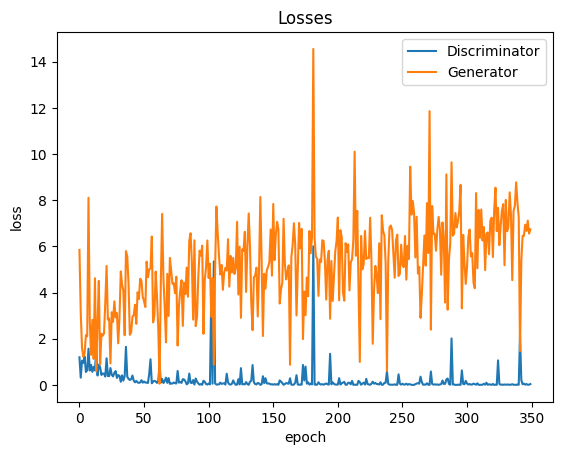

In [32]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

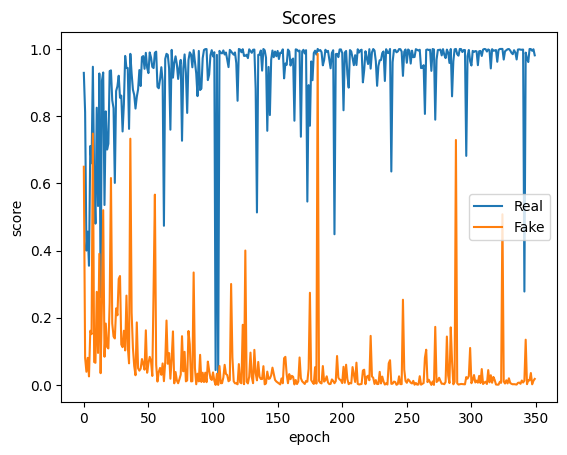

In [33]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Real Images
Fake Images


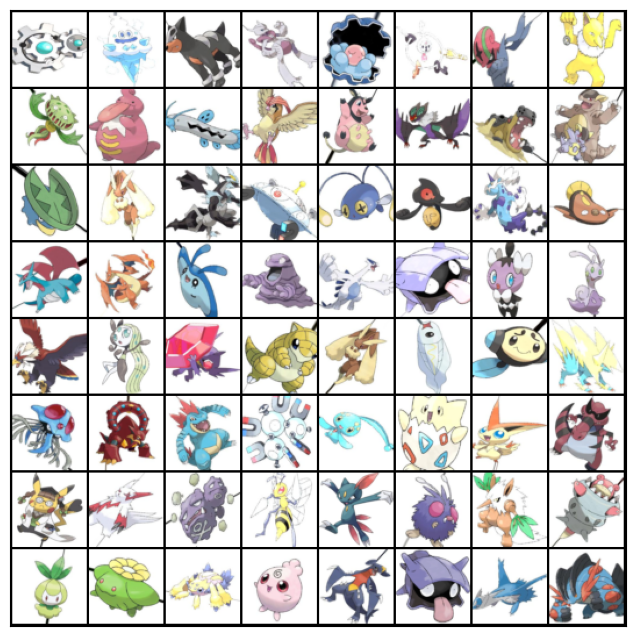

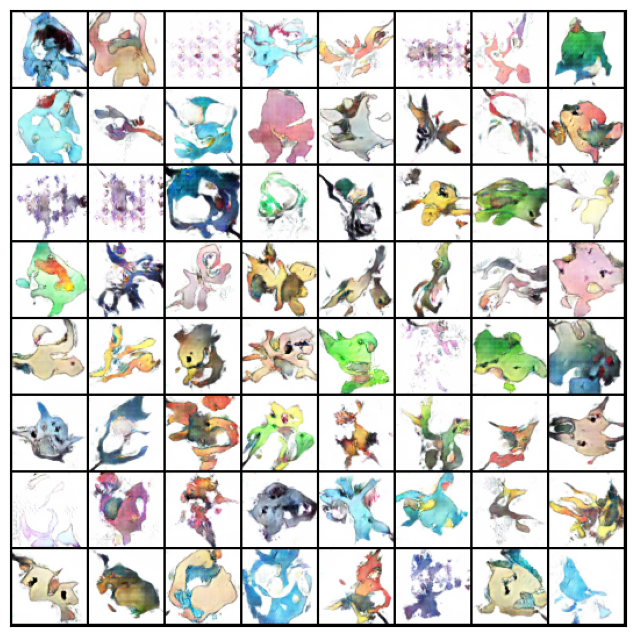

In [34]:
real_images, _ = next(iter(train_dataloader))

with torch.no_grad():
    latent = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    fake_images = generator(latent)

# showcase the real image
print("Real Images")
show_images(real_images.cpu())

# compare with fake image
print("Fake Images")
show_images(fake_images.cpu())


In [35]:
torch.save(generator.state_dict(), os.path.join(save_dir, 'generator_pokemonDCGAN.pth'))